In [1]:
# script
import findspark
findspark.init()
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

import seaborn as sns

# build spark session
spark = SparkSession \
    .builder \
    .appName("Load Hive Table") \
    .enableHiveSupport() \
    .getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

24/01/07 20:19:47 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
24/01/07 20:19:47 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
24/01/07 20:19:48 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [2]:
# get data
bikes = spark.sql("select * from bikes where ride_id !='ride_id'")
weather = spark.sql("select * from weather where name != 'name'")

# process weather data
tmp_weather = weather.withColumn("date", F.to_date('datetime')).groupBy('date').agg({
    'temp': 'mean',
    'precip': 'mean',
    'windspeed': 'mean',
})\
    .withColumnRenamed("avg(temp)", "avg_temp")\
    .withColumnRenamed("avg(precip)", "avg_precip")\
    .withColumnRenamed("avg(windspeed)", "avg_windspeed")
weather_avg = tmp_weather\
    .withColumn('avg_temp_bin', F.round(tmp_weather.avg_temp))\
    .withColumn('avg_precip_bin', F.round(tmp_weather.avg_precip * 100) / 100)\
    .withColumn('avg_windspeed_bin', F.round(tmp_weather.avg_windspeed)).select('date', 'avg_temp_bin', 'avg_precip_bin', 'avg_windspeed_bin')

# process bikes data
tmp_bikes = bikes.withColumn('start_timestamp', F.unix_timestamp('start_time', format='yyyy-MM-dd HH:mm:ss'))
tmp_bikes = tmp_bikes.withColumn('stop_timestamp', F.unix_timestamp('stop_time', format='yyyy-MM-dd HH:mm:ss'))
tmp_bikes = tmp_bikes.withColumn('duration', tmp_bikes.stop_timestamp - tmp_bikes.start_timestamp)
tmp_bikes = tmp_bikes.withColumn("date", F.to_date('start_time')).groupBy('date')\
    .agg(
        F.count(F.lit(1)).alias("ride_count"),
        F.sum('duration').alias("total_triptime"),
        F.mean('duration').alias("mean_triptime"),
    )
bike_rides = tmp_bikes.select('date', 'ride_count', 'total_triptime', 'mean_triptime')
weather_avg.join(bike_rides, on='date').createOrReplaceTempView("weather_and_rides")

df = spark.sql("select * from weather_and_rides")
df.show(3)

+----------+------------+--------------+-----------------+----------+--------------+-----------------+
|      date|avg_temp_bin|avg_precip_bin|avg_windspeed_bin|ride_count|total_triptime|    mean_triptime|
+----------+------------+--------------+-----------------+----------+--------------+-----------------+
|2021-01-27|         2.0|           0.0|              7.0|      3910|       3733899|954.9613810741688|
|2021-06-22|        21.0|          0.02|              8.0|      7512|       6260369|833.3824547390841|
|2021-08-27|        28.0|          0.27|              6.0|      8903|       7618320|855.7025721666854|
+----------+------------+--------------+-----------------+----------+--------------+-----------------+
only showing top 3 rows



In [3]:
# create analyses
df = spark.sql("select * from weather_and_rides")
rides_vs_temp = df.groupBy('avg_temp_bin').agg({'ride_count': 'mean'}).withColumnRenamed('avg(ride_count)', 'avg_ride_count').toPandas()
rides_vs_windspeed = df.groupBy('avg_windspeed_bin').agg({'ride_count': 'mean'}).withColumnRenamed('avg(ride_count)', 'avg_ride_count').toPandas()
rides_vs_precip = df.groupBy('avg_precip_bin').agg({'ride_count': 'mean'}).withColumnRenamed('avg(ride_count)', 'avg_ride_count').toPandas()

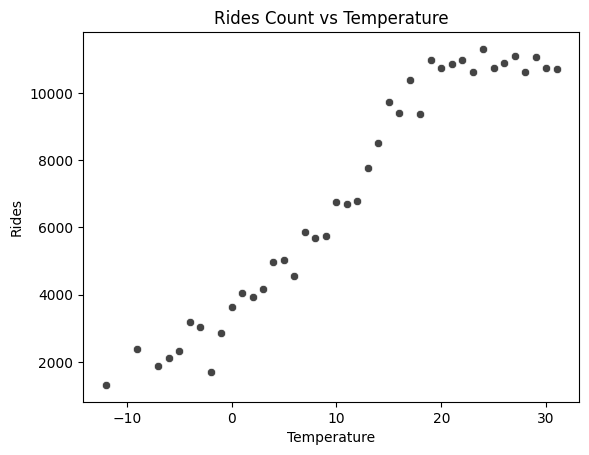

In [229]:
sns.scatterplot(data=rides_vs_temp, x='avg_temp_bin', y='avg_ride_count', c='#444444').set(
                xlabel='Temperature',
                ylabel='Rides',
                title='Rides Count vs Temperature')
plt.show()

[Text(0.5, 0, 'Precipitation'),
 Text(0, 0.5, 'Rides'),
 Text(0.5, 1.0, 'Rides Count vs Precipitation')]

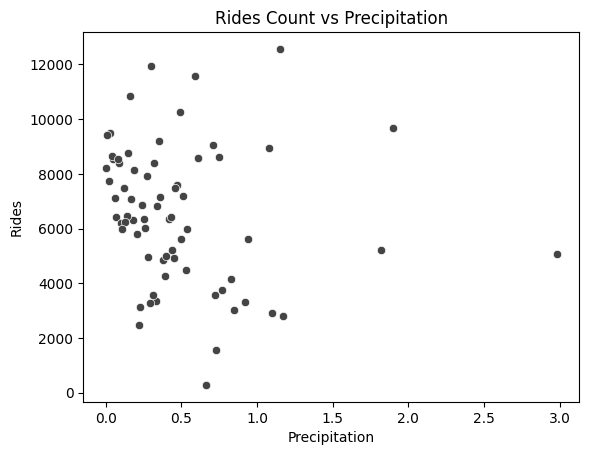

In [32]:
sns.scatterplot(data=rides_vs_precip, x='avg_precip_bin', y='avg_ride_count', c='#444444').set(
                xlabel='Precipitation',
                ylabel='Rides',
                title='Rides Count vs Precipitation')

[Text(0.5, 0, 'Wind Speed'),
 Text(0, 0.5, 'Rides'),
 Text(0.5, 1.0, 'Rides Count vs Wind Speed')]

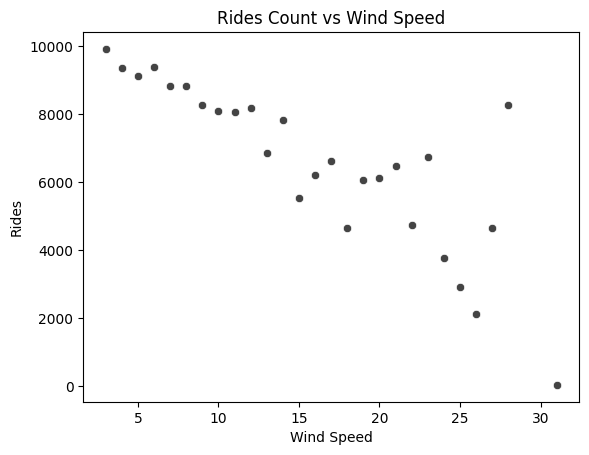

In [33]:
sns.scatterplot(data=rides_vs_windspeed, x='avg_windspeed_bin', y='avg_ride_count',  c='#444444').set(
                xlabel='Wind Speed',
                ylabel='Rides',
                title='Rides Count vs Wind Speed')

In [13]:
rides_vs_temp_windspeed = df.groupBy('avg_temp_bin', 'avg_windspeed_bin').agg({'ride_count': 'mean'}).withColumnRenamed('avg(ride_count)', 'avg_ride_count').toPandas()

In [40]:
import matplotlib.pyplot as plt

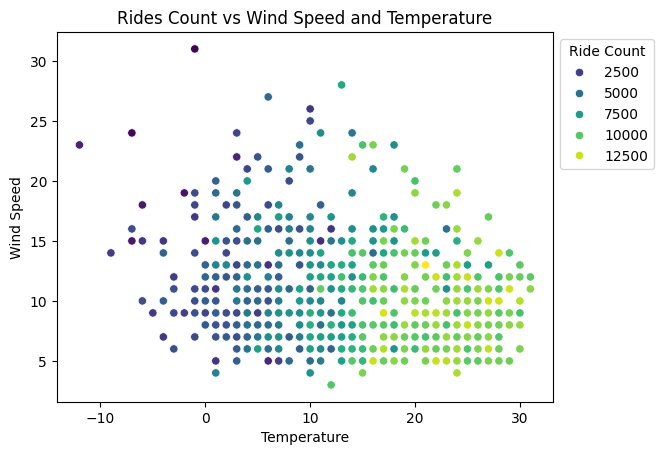

In [43]:
sns.scatterplot(
    data=rides_vs_temp_windspeed, x='avg_temp_bin', y='avg_windspeed_bin', hue='avg_ride_count', palette='viridis').set(
                xlabel='Temperature',
                ylabel='Wind Speed',
                title='Rides Count vs Wind Speed and Temperature')
plt.legend(title="Ride Count", bbox_to_anchor=(1.0, 1), loc='upper left')
plt.show()

In [8]:
tmp = df.groupBy('avg_precip_bin').agg(
    F.sum('total_triptime').alias('total_triptime'),
    F.sum('ride_count').alias('ride_count'),
)
triptime_vs_precip = tmp.withColumn('mean_triptime', tmp.total_triptime/tmp.ride_count)

<Axes: xlabel='avg_precip_bin', ylabel='mean_triptime'>

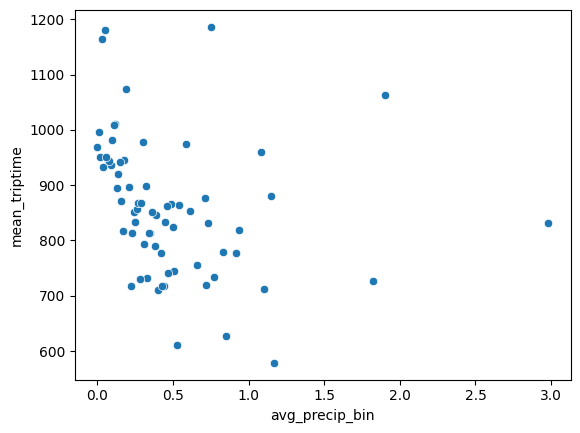

In [12]:
sns.scatterplot(data=triptime_vs_precip.toPandas(), x='avg_precip_bin', y='mean_triptime')

### Umieszczanie danych w HBase

In [10]:
import happybase
from tqdm.notebook import tqdm

class MyConnection:

    def __init__(self, host='localhost'):
        self.connection = happybase.Connection(host, autoconnect=False, port=9090)

    def __enter__(self):
        self.connection.open()
        return self.connection

    def __exit__(self, type, value, traceback):
        self.connection.close()

In [11]:
df_pd = spark.sql("select * from weather_and_rides").toPandas()


In [12]:
TABLE_NAME = "weather_and_rides"

with MyConnection() as connection:
    print("checking if the table already exists...")
    if TABLE_NAME.encode() in connection.tables():
        print("droping an existing table...")
        connection.delete_table(TABLE_NAME, disable=True)
    print("creating a new table...")
    connection.create_table(
        TABLE_NAME,
        {'time': dict(),
         'weather': dict(),
         'rides': dict(),  # use defaults
        }
    )
    print("getting table...")
    table = connection.table(TABLE_NAME)
    print("putting data...")
    with tqdm(total=df_pd.shape[0]) as pbar:
        for index, row in df_pd.iterrows():
            pbar.update(1)
            row_key = row['date'].strftime('%Y-%m-%d')[::-1].replace('-', '') # reversed date string
            data = {
                b'time:date': (f"{row['date'].strftime('%Y-%m-%d')}").encode(),
                b'weather:avg_temp_bin': (f"{row['avg_temp_bin']}").encode(),
                b'weather:avg_windspeed_bin': (f"{row['avg_windspeed_bin']}").encode(),
                b'weather:avg_precip_bin': (f"{row['avg_precip_bin']}").encode(),
                b'rides:ride_count': (f"{row['ride_count']}").encode(),
                b'rides:total_triptime': (f"{row['total_triptime']}").encode(),
                b'rides:mean_triptime': (f"{row['mean_triptime']}").encode(),
            }        
            table.put(row_key.encode(), data)

checking if the table already exists...
droping an existing table...
creating a new table...
getting table...
putting data...


  0%|          | 0/729 [00:00<?, ?it/s]

In [31]:
with MyConnection() as connection:
    t = connection.table(TABLE_NAME)
    print(t.row(b'72101202'))

{b'rides:mean_triptime': b'954.9613810741688', b'rides:ride_count': b'3910', b'rides:total_triptime': b'3733899', b'time:date': b'2021-01-27', b'weather:avg_precip_bin': b'0.0', b'weather:avg_temp_bin': b'2.0', b'weather:avg_windspeed_bin': b'7.0'}


### Trip Time

In [45]:
tmp_bikes = bikes.withColumn('start_timestamp', F.unix_timestamp('start_time', format='yyyy-MM-dd HH:mm:ss'))
tmp_bikes = tmp_bikes.withColumn('stop_timestamp', F.unix_timestamp('stop_time', format='yyyy-MM-dd HH:mm:ss'))
tmp_bikes = tmp_bikes.withColumn('duration', tmp_bikes.stop_timestamp - tmp_bikes.start_timestamp)
bikes_durations = tmp_bikes

In [82]:
bikes_durations = bikes_durations.withColumn("timestamp", F.to_timestamp(bikes_durations.start_time, 'yyyy-MM-dd HH:mm:ss'))
bikes_durations = bikes_durations.withColumn("time_of_day", 
     (F.round(F.hour(bikes_durations.timestamp) * 60 + F.minute(bikes_durations.timestamp) + F.second(bikes_durations.timestamp) / 60)) % 1440)
# bikes_durations.select('timestamp', 'day_minute', 'duration').count()

In [87]:
tmp = bikes_durations.groupBy('time_of_day').agg(
    F.count(F.lit(1)).alias("ride_count"),
    F.mean('duration').alias("mean_duration")
)

tmp = tmp.withColumn("hour", F.round(tmp.time_of_day / 60))
tmp = tmp.withColumn("quarter", F.round(tmp.time_of_day / 15))
rides_vs_time_of_day = tmp.toPandas()

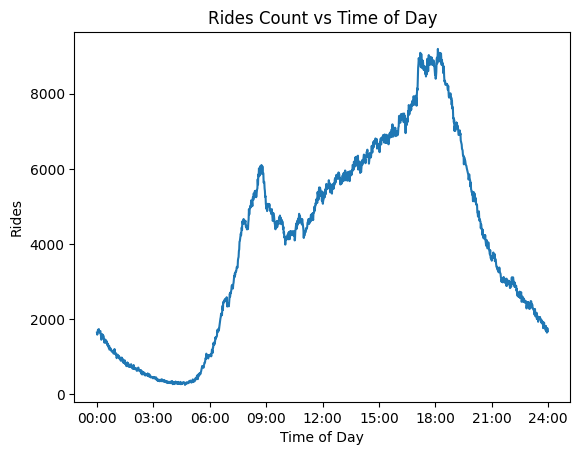

In [100]:
sns.lineplot(data=rides_vs_time_of_day, x='time_of_day', y='ride_count').set(
                xlabel='Time of Day',
                ylabel='Rides',
                title='Rides Count vs Time of Day')

ticks_per_hour = 60
hours = range(0, 25, 3)
ticks_location = [hour * ticks_per_hour for hour in hours]
ticks_labels = [f'{hour:02d}:00' for hour in hours]

plt.xticks(ticks=ticks_location, labels=ticks_labels)
plt.show()

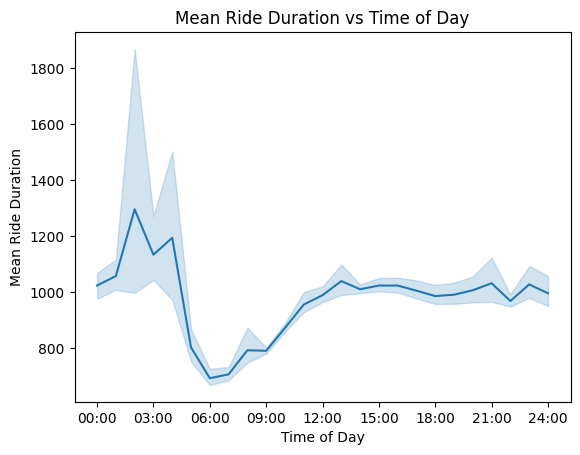

In [101]:
sns.lineplot(data=rides_vs_time_of_day, x='hour', y='mean_duration').set(
                xlabel='Time of Day',
                ylabel='Mean Ride Duration',
                title='Mean Ride Duration vs Time of Day')

ticks_per_hour = 1
hours = range(0, 25, 3)
ticks_location = [hour * ticks_per_hour for hour in hours]
ticks_labels = [f'{hour:02d}:00' for hour in hours]

plt.xticks(ticks=ticks_location, labels=ticks_labels)
plt.show()

In [173]:
bikes_day = bikes.withColumn('date', F.date_format(F.to_date('start_round_hour', format='yyyy-MM-dd HH:mm:ss'), 'yyyy-MM-dd'))
bikes_day = bikes_day.filter(bikes_day.date == '2022-11-11')

weather_day = weather.withColumn('date', F.date_format(F.to_date('datetime', format='yyyy-MM-dd HH:mm:ss'), 'yyyy-MM-dd'))
weather_day= weather_day.filter(weather_day.date == '2022-11-11')

In [174]:
tmp_bikes = bikes_day.withColumn('start_timestamp', F.unix_timestamp('start_time', format='yyyy-MM-dd HH:mm:ss'))
tmp_bikes = tmp_bikes.withColumn('stop_timestamp', F.unix_timestamp('stop_time', format='yyyy-MM-dd HH:mm:ss'))
tmp_bikes = tmp_bikes.withColumn('duration', tmp_bikes.stop_timestamp - tmp_bikes.start_timestamp)
tmp_bikes = tmp_bikes.withColumn("timestamp", F.to_timestamp(tmp_bikes.start_time, 'yyyy-MM-dd HH:mm:ss'))
tmp_bikes = tmp_bikes.withColumn("time_of_day", 
     (F.round(F.hour(tmp_bikes.timestamp) * 60 + F.minute(tmp_bikes.timestamp) + F.second(tmp_bikes.timestamp) / 60)) % 1440)\
    .select('time_of_day', 'duration')

tmp_bikes = tmp_bikes.withColumn("hour", F.round(tmp_bikes.time_of_day / 60))
bikes_day = tmp_bikes.groupBy('hour').agg(
        F.count(F.lit(1)).alias("ride_count"),
        F.mean('duration').alias("mean_duration")
    ).toPandas()

In [175]:
weather_day = weather_day.withColumn("hour", F.hour(F.to_timestamp('datetime', format='yyyy-MM-dd HH:mm:ss'))).select('precip', 'hour').toPandas()

In [223]:
import pandas as pd
day = pd.merge(bikes_day, weather_day, on='hour')
day = day[['hour', 'ride_count', 'precip']]
day['precip'] = day['precip'] * 100

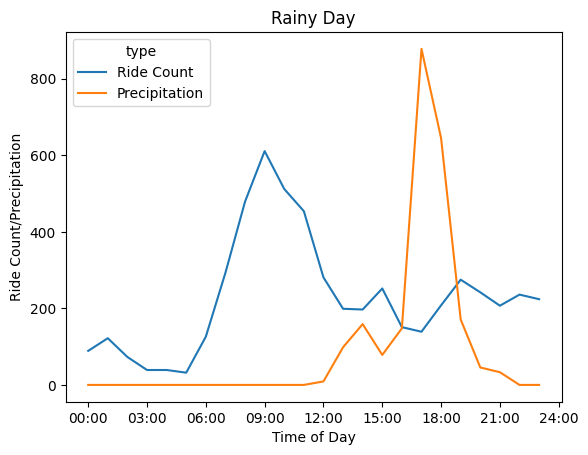

In [230]:
sns.lineplot(
    data=pd.melt(
        day.rename(columns={'ride_count': 'Ride Count', 'precip': 'Precipitation'}), ['hour'])\
        .rename(columns={'variable': 'type'}), x='hour', hue='type', y='value').set(
                xlabel='Time of Day',
                ylabel='Ride Count/Precipitation',
                title='Rainy Day')

ticks_per_hour = 1
hours = range(0, 25, 3)
ticks_location = [hour * ticks_per_hour for hour in hours]
ticks_labels = [f'{hour:02d}:00' for hour in hours]

plt.xticks(ticks=ticks_location, labels=ticks_labels)
plt.show()